In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', 100)

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import re
import string
import nltk
import xgboost

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV

import sys


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix

from textblob import TextBlob, Word
from wordcloud import WordCloud

In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/elliott/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
data = pd.read_csv("../../../data/fps_main.csv")
data.head()


,steamid,appid,app_title,app_tags,review,fps,voted_up
0,76561198865552498,730,Counter-Strike: Global Offensive,"['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action', 'Team-Based', 'eSports', 'Tactical', ...",very good game,True,1
1,76561197964533061,730,Counter-Strike: Global Offensive,"['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action', 'Team-Based', 'eSports', 'Tactical', ...",beause S,True,1
2,76561198290998839,730,Counter-Strike: Global Offensive,"['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action', 'Team-Based', 'eSports', 'Tactical', ...","Russians everywhere, do not recommend",True,1
3,76561198073021168,60,Ricochet,"['Action', 'FPS', 'Multiplayer', 'Classic', 'First-Person', 'Sci-fi', 'Shooter', 'Space', 'Cyber...","best game, best game, 10/10 i r8 8/8",True,1
4,76561198061142423,550,Left 4 Dead 2,"['Zombies', 'Co-op', 'FPS', 'Multiplayer', 'Shooter', 'Action', 'Online Co-Op', 'Survival', 'Hor...",køb hvis du kan lide zombie spil ;D,True,1


In [3]:
data["voted_up"] = data["voted_up"].astype(int)

data.head()

,steamid,appid,app_title,app_tags,review,fps,voted_up
0,76561198865552498,730,Counter-Strike: Global Offensive,"['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action', 'Team-Based', 'eSports', 'Tactical', ...",very good game,True,1
1,76561197964533061,730,Counter-Strike: Global Offensive,"['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action', 'Team-Based', 'eSports', 'Tactical', ...",beause S,True,1
2,76561198290998839,730,Counter-Strike: Global Offensive,"['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action', 'Team-Based', 'eSports', 'Tactical', ...","Russians everywhere, do not recommend",True,1
3,76561198073021168,60,Ricochet,"['Action', 'FPS', 'Multiplayer', 'Classic', 'First-Person', 'Sci-fi', 'Shooter', 'Space', 'Cyber...","best game, best game, 10/10 i r8 8/8",True,1
4,76561198061142423,550,Left 4 Dead 2,"['Zombies', 'Co-op', 'FPS', 'Multiplayer', 'Shooter', 'Action', 'Online Co-Op', 'Survival', 'Hor...",køb hvis du kan lide zombie spil ;D,True,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19680 entries, 0 to 19679
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   steamid    19680 non-null  int64 
 1   appid      19680 non-null  int64 
 2   app_title  19680 non-null  object
 3   app_tags   19680 non-null  object
 4   review     19680 non-null  object
 5   fps        19680 non-null  bool  
 6   voted_up   19680 non-null  int64 
dtypes: bool(1), int64(3), object(3)
memory usage: 941.8+ KB


In [5]:
data["voted_up"].value_counts(normalize=True)

0    0.515091
1    0.484909
Name: voted_up, dtype: float64

In [6]:
def CleanText(reviews):
    stopwords = nltk.corpus.stopwords.words('english')
    punct = string.punctuation
    lemma = nltk.WordNetLemmatizer()
    
    reviews = "".join([word for word in reviews if word not in string.punctuation])
    tokens = re.split('\W+', reviews)
    reviews = [lemma.lemmatize(word) for word in tokens if word not in stopwords]
    
# use function like this in your notebook
# df['cleaned_text'] = df['text'].apply(lambda x: CleanText(x.lower()))
    
    return reviews


In [7]:
data['clean_review'] = data['review'].apply(lambda x: CleanText(x.lower()))

data.head()

,steamid,appid,app_title,app_tags,review,fps,voted_up,clean_review
0,76561198865552498,730,Counter-Strike: Global Offensive,"['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action', 'Team-Based', 'eSports', 'Tactical', ...",very good game,True,1,"[good, game]"
1,76561197964533061,730,Counter-Strike: Global Offensive,"['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action', 'Team-Based', 'eSports', 'Tactical', ...",beause S,True,1,"[, beause]"
2,76561198290998839,730,Counter-Strike: Global Offensive,"['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action', 'Team-Based', 'eSports', 'Tactical', ...","Russians everywhere, do not recommend",True,1,"[russian, everywhere, recommend]"
3,76561198073021168,60,Ricochet,"['Action', 'FPS', 'Multiplayer', 'Classic', 'First-Person', 'Sci-fi', 'Shooter', 'Space', 'Cyber...","best game, best game, 10/10 i r8 8/8",True,1,"[best, game, best, game, 1010, r8, 88]"
4,76561198061142423,550,Left 4 Dead 2,"['Zombies', 'Co-op', 'FPS', 'Multiplayer', 'Shooter', 'Action', 'Online Co-Op', 'Survival', 'Hor...",køb hvis du kan lide zombie spil ;D,True,1,"[køb, hvis, du, kan, lide, zombie, spil]"


In [8]:
df_down = data.loc[data['voted_up'] == 0]
df_up = data.loc[data['voted_up'] == 1]

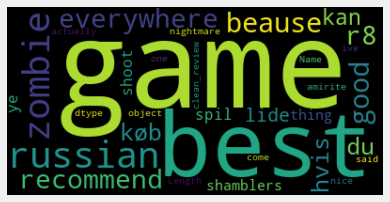

<Figure size 1440x720 with 0 Axes>

In [11]:
wordcloud = WordCloud(max_words=10000, width=400, height=200).generate(str(df_up["clean_review"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

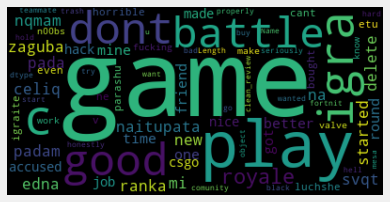

<Figure size 1440x720 with 0 Axes>

In [12]:
wordcloud = WordCloud(max_words=10000, width=400, height=200).generate(str(df_down["clean_review"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

In [21]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/elliott/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

<AxesSubplot:>

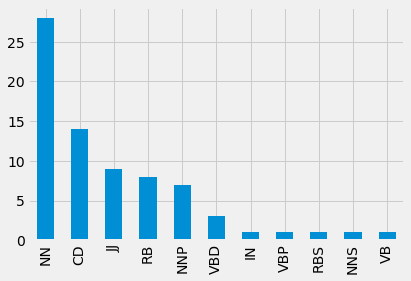

In [24]:
blob = TextBlob(str(df_up["clean_review"]))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(kind='bar', title="" )

<AxesSubplot:>

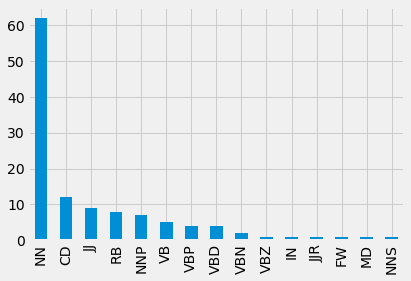

In [37]:
blob = TextBlob(str(df_down["clean_review"]))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(kind='bar', title="" )


In [38]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3) * 100

data['percent_punct'] = data['app_tags'].apply(lambda x: count_punct(x))
data.head()

,steamid,appid,app_title,app_tags,review,fps,voted_up,clean_review,percent_punct
0,76561198865552498,730,Counter-Strike: Global Offensive,"['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action', 'Team-Based', 'eSports', 'Tactical', ...",very good game,True,1,"[good, game]",30.4
1,76561197964533061,730,Counter-Strike: Global Offensive,"['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action', 'Team-Based', 'eSports', 'Tactical', ...",beause S,True,1,"[, beause]",30.4
2,76561198290998839,730,Counter-Strike: Global Offensive,"['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action', 'Team-Based', 'eSports', 'Tactical', ...","Russians everywhere, do not recommend",True,1,"[russian, everywhere, recommend]",30.4
3,76561198073021168,60,Ricochet,"['Action', 'FPS', 'Multiplayer', 'Classic', 'First-Person', 'Sci-fi', 'Shooter', 'Space', 'Cyber...","best game, best game, 10/10 i r8 8/8",True,1,"[best, game, best, game, 1010, r8, 88]",27.4
4,76561198061142423,550,Left 4 Dead 2,"['Zombies', 'Co-op', 'FPS', 'Multiplayer', 'Shooter', 'Action', 'Online Co-Op', 'Survival', 'Hor...",køb hvis du kan lide zombie spil ;D,True,1,"[køb, hvis, du, kan, lide, zombie, spil]",28.0


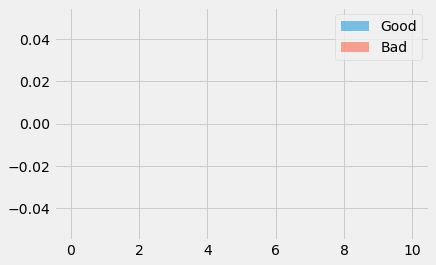

In [39]:
#bins = np.linspace(0, 10, 60)
plt.hist(data[data['fps'] == 'Good']['percent_punct'], bins, alpha=0.5, label='Good')
plt.hist(data[data['fps'] == 'Bad']['percent_punct'], bins, alpha=0.5, label='Bad')
plt.legend(loc='upper right')
plt.show()